# cycleGANs for STEM images

In this section, we'll train a GAN to noise up a simulated image to look like an experimental image

## Imports

In [1]:
from make_dataset import parse_and_save_dir, load_train_data
from models import unet_generator, discriminator, generator_resnet
import tensorflow as tf
from plotting_tools import *
import pickle
import time
from glob import glob
from IPython.display import clear_output

## Loading in Images
First, we load in a simulated image and experimental image, and cut them into 256x256 chunks. We then store the images in folders.

In [2]:
parent_dir = "C:/Users/abidk/Dropbox/Development/programs/stem-learning/code/cycle_gan/"
exp_dir_raw = parent_dir + "data/RR/"
sim_dir_raw = parent_dir + "data/sim_image/"

exp_dir = parent_dir + "data/exp_256/"
sim_dir = parent_dir + "data/sim_256/"

fine_size, stride = 256, 256
num_channels=1

In [3]:
#parse_and_save_dir(exp_dir_raw, exp_dir, fine_size, stride)
#parse_and_save_dir(sim_dir_raw, sim_dir, fine_size, stride, num_channels=num_channels)

## Construct Generator and Discriminator

In [4]:
generator_exp = unet_generator(num_channels, 1, "instancenorm")
generator_sim = unet_generator(1, num_channels, "instancenorm")

#generator_exp = generator_resnet(64, num_channels, 1)
#generator_sim = generator_resnet(64, 1, num_channels)

discriminator_sim = discriminator("instancenorm", num_channels)
discriminator_exp = discriminator("instancenorm", 1)

In [5]:
lr0 = 2e-3
generator_exp_optimizer = tf.keras.optimizers.Adam(lr0)
generator_sim_optimizer = tf.keras.optimizers.Adam(lr0)

discriminator_sim_optimizer = tf.keras.optimizers.Adam(lr0)
discriminator_exp_optimizer = tf.keras.optimizers.Adam(lr0)

## Loss Functions and Accuracies

In [6]:
LAMBDA = 40

#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_obj( tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss * 0.5

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def L1_loss(img_A, img_B):
    return tf.reduce_mean(tf.abs(img_A - img_B))

def L2_loss(img_A, img_B):
    diff = tf.abs(img_A - img_B)
    return tf.reduce_mean(diff*diff)

## Checkpoints

In [7]:
identifier = "20210921_unet_dist_gen"
checkpoint_path = parent_dir + "checkpoints/checkpoint_{}".format(identifier)
log_data_fn = "{}/data_{}.p".format(checkpoint_path, identifier)

ckpt = tf.train.Checkpoint(generator_exp=generator_exp,
                           generator_sim=generator_sim,
                           discriminator_sim=discriminator_sim,
                           discriminator_exp=discriminator_exp,
                           generator_exp_optimizer=generator_exp_optimizer,
                           generator_sim_optimizer=generator_sim_optimizer,
                           discriminator_sim_optimizer=discriminator_sim_optimizer,
                           discriminator_exp_optimizer=discriminator_exp_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    #cpath = ckpt_manager.checkpoints[-2]
    cpath = ckpt_manager.latest_checkpoint
    print("loading checkpoint ", cpath)
    ckpt.restore(cpath)
    print ('Latest checkpoint restored!')

loading checkpoint  C:/Users/abidk/Dropbox/Development/programs/stem-learning/code/cycle_gan/checkpoints/checkpoint_20210921_unet_dist_gen\ckpt-39
Latest checkpoint restored!


## Training Functions

In [8]:
@tf.function
def train_generators(real_sim, real_exp, train=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_exp   = generator_exp(real_sim, training=train)
    cycled_sim = generator_sim(fake_exp, training=train)

    fake_sim   = generator_sim(real_exp, training=train)
    cycled_exp = generator_exp(fake_sim, training=train)

    disc_fake_sim = discriminator_sim(fake_sim, training=False)
    disc_fake_exp = discriminator_exp(fake_exp, training=False)

    # calculate the loss
    gen_exp_loss = generator_loss(disc_fake_exp)
    gen_sim_loss = generator_loss(disc_fake_sim)

    cycle_exp_loss = L1_loss(real_exp, cycled_exp)
    cycle_sim_loss = L1_loss(real_sim, cycled_sim)
    total_cycle_loss = cycle_exp_loss + cycle_sim_loss

    dist_gen_exp_loss = L1_loss(real_sim, fake_exp)
    dist_gen_sim_loss = L1_loss(real_exp, fake_sim)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_exp_loss = gen_exp_loss + LAMBDA*total_cycle_loss + 0.1*LAMBDA*dist_gen_exp_loss
    total_gen_sim_loss = gen_sim_loss + LAMBDA*total_cycle_loss + 0.1*LAMBDA*dist_gen_sim_loss
  
  if train:
    # Calculate the gradients for generator and discriminator
    generator_exp_gradients = tape.gradient(total_gen_exp_loss, generator_exp.trainable_variables)
    generator_sim_gradients = tape.gradient(total_gen_sim_loss, generator_sim.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_exp_optimizer.apply_gradients(zip(generator_exp_gradients, generator_exp.trainable_variables))
    generator_sim_optimizer.apply_gradients(zip(generator_sim_gradients, generator_sim.trainable_variables))

  return cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss, dist_gen_exp_loss, dist_gen_sim_loss

@tf.function
def train_discriminators(real_sim, real_exp, train=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_exp   = generator_exp(real_sim, training=train)
    fake_sim   = generator_sim(real_exp, training=train)

    disc_real_sim = discriminator_sim(real_sim, training=train)
    disc_fake_sim = discriminator_sim(fake_sim, training=train)

    disc_real_exp = discriminator_exp(real_exp, training=train)
    disc_fake_exp = discriminator_exp(fake_exp, training=train)
    
    # Calculate loss
    disc_sim_loss = discriminator_loss(disc_real_sim, disc_fake_sim)
    disc_exp_loss = discriminator_loss(disc_real_exp, disc_fake_exp)
  
  if train:
    # Calculate the gradients for generator and discriminator
    discriminator_sim_gradients = tape.gradient(disc_sim_loss, discriminator_sim.trainable_variables)
    discriminator_exp_gradients = tape.gradient(disc_exp_loss, discriminator_exp.trainable_variables)
  
    # Apply the gradients to the optimizer
    discriminator_sim_optimizer.apply_gradients(zip(discriminator_sim_gradients, discriminator_sim.trainable_variables))
    discriminator_exp_optimizer.apply_gradients(zip(discriminator_exp_gradients, discriminator_exp.trainable_variables))
  return disc_sim_loss, disc_exp_loss

## Training

In [9]:
gen_exp_losses,   gen_sim_losses   = [], []
disc_exp_losses,  disc_sim_losses  = [], []
cycle_exp_losses, cycle_sim_losses = [], []
dist_gen_exp_losses, dist_gen_sim_losses = [], []
disc_exp_accs,    disc_sim_accs    = [], []
epoch = 0
batch_size = 32
train_size = 10000
total_epochs = 200
epoch_step   = 100

try:
    ( gen_exp_losses,   gen_sim_losses, 
     disc_exp_losses,  disc_sim_losses, 
    cycle_exp_losses, cycle_sim_losses,
    dist_gen_exp_losses, dist_gen_sim_losses,
     disc_exp_accs,    disc_sim_accs,      
     epoch) = pickle.load(open(log_data_fn, "rb" ))
    print("loading at epoch ", epoch)
except Exception as e:
    print(e)
    pass
last=None

loading at epoch  174


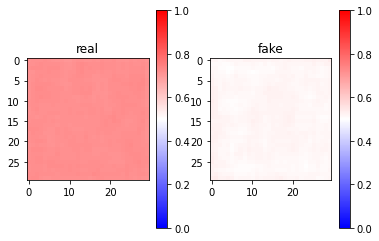

28800 28800
TP: 28800
FP: 0
FN: 19230
TN: 9570
recall:    0.5996252342286071
precision: 1.0
accuracy:  0.6661458333333333


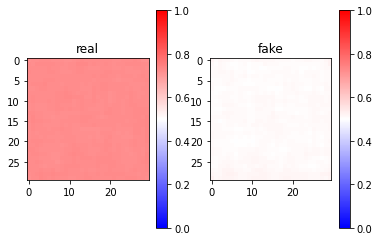

28800 28800
TP: 28800
FP: 0
FN: 19346
TN: 9454
recall:    0.5981805342084493
precision: 1.0
accuracy:  0.6641319444444445


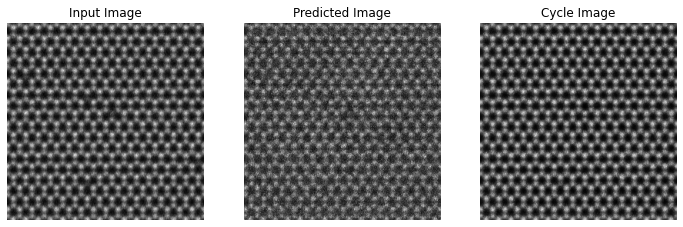

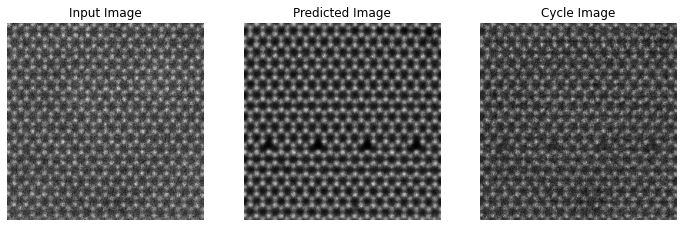

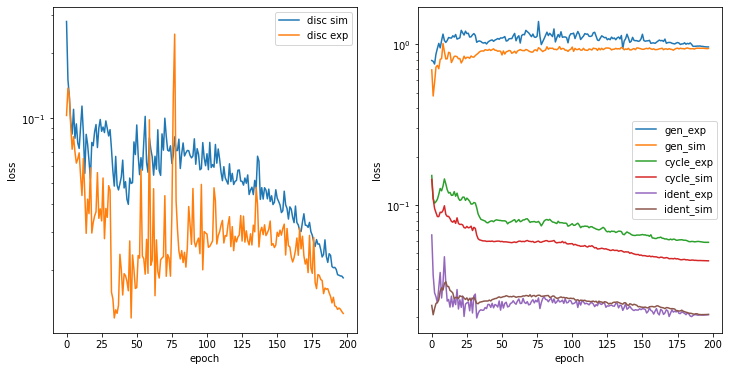

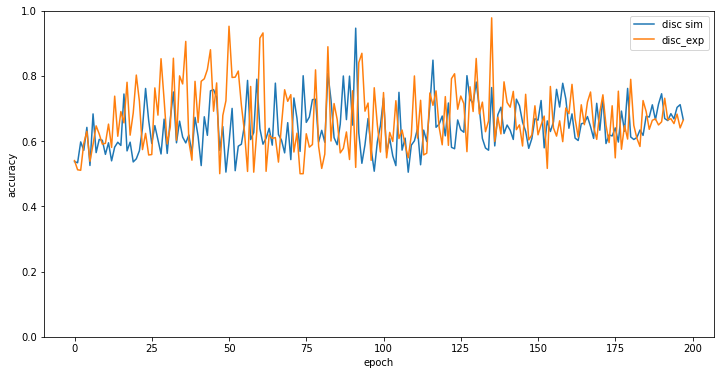

Time taken for epoch 198 is 64.13849902153015 sec

198 2.020202020202011e-05
[0/53]: 0.03634428232908249
[1/53]: 0.03634914010763168
[2/53]: 0.03706049174070358
[3/53]: 0.03670794516801834
[4/53]: 0.03647163510322571
[5/53]: 0.03645459562540054
[6/53]: 0.0364912748336792
[7/53]: 0.03655526041984558
[8/53]: 0.03642196208238602
[9/53]: 0.03649713844060898
[10/53]: 0.036509014666080475
[11/53]: 0.036423131823539734
[12/53]: 0.03649941831827164
[13/53]: 0.03639550507068634
[14/53]: 0.03647296875715256
[15/53]: 0.037118665874004364
[16/53]: 0.036454543471336365
[17/53]: 0.036439768970012665
[18/53]: 0.03642502427101135
[19/53]: 0.03648170083761215
[20/53]: 0.03644757717847824
[21/53]: 0.03647041320800781
[22/53]: 0.03646009415388107
[23/53]: 0.036449819803237915
[24/53]: 0.036406971514225006
[25/53]: 0.03717096894979477
[26/53]: 0.03981485217809677
[27/53]: 0.03725633770227432
[28/53]: 0.03644724190235138
[29/53]: 0.03640885651111603
[30/53]: 0.036403387784957886
[31/53]: 0.0371768921613693

In [10]:
while epoch < total_epochs:
    start = time.time()
    lr = lr0*(1 - (epoch - epoch_step)/(total_epochs-1 - epoch_step)) if epoch >= epoch_step else lr0
    print(epoch, lr)
    generator_exp_optimizer.lr.assign(lr/(1+2.25*LAMBDA))
    generator_sim_optimizer.lr.assign(lr/(1+2.25*LAMBDA))
    discriminator_sim_optimizer.lr.assign(lr)
    discriminator_exp_optimizer.lr.assign(lr)

    data_sim = glob('{}/*.*'.format(sim_dir))
    data_exp = glob('{}/*.*'.format(exp_dir))
    np.random.shuffle(data_sim)
    np.random.shuffle(data_exp)
    batch_idxs = min(min(len(data_sim), len(data_exp)), train_size) // batch_size

    dis_losses, gen_losses = np.zeros(2), np.zeros(6)
    for idx in range(0, batch_idxs):
        batch_start =  time.time()
        sim_fn_list = data_sim[idx*batch_size:(idx + 1)*batch_size]
        exp_fn_list = data_exp[idx*batch_size:(idx + 1)*batch_size]

        real_sim = np.array([load_train_data(fn, num_channels) for fn in sim_fn_list]).astype(np.float32)
        real_exp = np.array([load_train_data(fn, num_channels) for fn in exp_fn_list]).astype(np.float32)

        dis_losses += train_discriminators(real_sim, real_exp, train=True)
        gen_losses += train_generators(real_sim, real_exp, train=True)

        print("[{}/{}]: {}".format(idx, batch_idxs, (time.time()-batch_start)/batch_size))

    clear_output(wait=True)

    cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss, dist_gen_exp_loss, dist_gen_sim_loss= gen_losses/batch_idxs
    disc_sim_loss, disc_exp_loss = dis_losses/batch_idxs

    # Calculate accuracy
    fake_sim = generator_sim(real_exp, training=False)
    fake_exp = generator_exp(real_sim, training=False)

    disc_sim_acc = get_discriminator_acc(discriminator_sim, real_sim, fake_sim, threshold=0.5)
    disc_exp_acc = get_discriminator_acc(discriminator_exp, real_exp, fake_exp, threshold=0.5)

    gen_exp_losses.append(gen_exp_loss)
    gen_sim_losses.append(gen_sim_loss)
    cycle_exp_losses.append(cycle_exp_loss)
    cycle_sim_losses.append(cycle_sim_loss)
    dist_gen_exp_losses.append(dist_gen_exp_loss)
    dist_gen_sim_losses.append(dist_gen_sim_loss)
    disc_sim_losses.append(disc_sim_loss)
    disc_exp_losses.append(disc_exp_loss)
    disc_sim_accs.append(disc_sim_acc)
    disc_exp_accs.append(disc_exp_acc)
    epoch += 1

    sample_sim = real_sim[0].reshape([1,fine_size,fine_size,num_channels])
    sample_exp = real_exp[0].reshape([1,fine_size,fine_size,1])
    generate_images(generator_exp, generator_sim, sample_sim)
    generate_images(generator_sim, generator_exp, sample_exp)
    generate_losses(gen_exp_losses,   gen_sim_losses,
                    cycle_exp_losses, cycle_sim_losses,
                    dist_gen_exp_losses, dist_gen_sim_losses,
                    disc_sim_losses,  disc_exp_losses,   epoch, last=last)
    generate_accuracies(disc_sim_accs, disc_exp_accs, epoch, last=last)

    if (epoch) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))
        pickle.dump( (    gen_exp_losses,   gen_sim_losses, 
                         disc_exp_losses,  disc_sim_losses, 
                        cycle_exp_losses, cycle_sim_losses,
                        dist_gen_exp_losses, dist_gen_sim_losses,
                         disc_exp_accs,    disc_sim_accs,      
                        epoch-1),
                     open( log_data_fn, "wb" ) )

    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))

In [ ]:
import matplotlib.pyplot as plt
i = 2
fn_list = [x for x in os.listdir(sim_dir) if ".tif" in x]
fn = fn_list[i]
print(fn)
img = load_train_data(os.path.join(sim_dir,fn))
for i in range(num_channels):
    plt.figure()
    plt.imshow(img[:,:,i])
plt.show()

sim_stack0_002.tiff


TypeError: load_train_data() missing 1 required positional argument: 'num_channels'